In [32]:
import os
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind, f_oneway
import optuna

extract_folder = "PD_data"

mat_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith(".mat")]

all_data_train = []
all_data_test = []

for file in mat_files:
    mat_contents = scipy.io.loadmat(file)
    
    # Extract column labels
    data_labels = [label[0] for label in mat_contents["data_labels"].flatten()]
    
    # Convert data_train and data_test to DataFrames
    train_df = pd.DataFrame(mat_contents["data_train"], columns=data_labels)
    test_df = pd.DataFrame(mat_contents["data_test"], columns=data_labels)
    
    # Add participant ID
    participant_id = os.path.basename(file).replace(".mat", "")
    train_df["participant_id"] = participant_id
    test_df["participant_id"] = participant_id
    
    # Append to lists
    all_data_train.append(train_df)
    all_data_test.append(test_df)

# Combine all participants' data
full_data_train_df = pd.concat(all_data_train, ignore_index=True)
full_data_test_df = pd.concat(all_data_test, ignore_index=True)

In [25]:
# Exclude non-numeric columns before correlation analysis
numeric_train_df = full_data_train_df.select_dtypes(include=[np.number])
numeric_test_df = full_data_test_df.select_dtypes(include=[np.number])

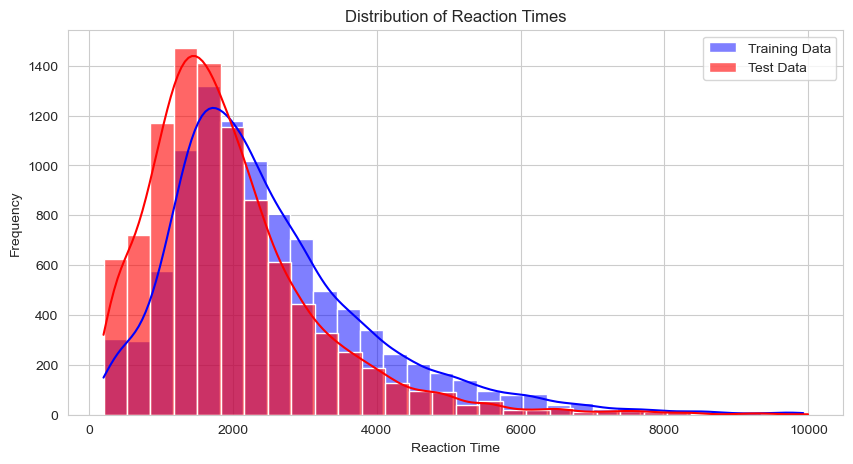

In [26]:
# Visualization
sns.set_style("whitegrid")

# Histogram of Reaction Times
plt.figure(figsize=(10, 5))
sns.histplot(full_data_train_df['RT'].dropna(), bins=30, kde=True, color='blue', label='Training Data')
sns.histplot(full_data_test_df['RT'].dropna(), bins=30, kde=True, color='red', label='Test Data', alpha=0.6)
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times')
plt.legend()
plt.show()

- The histogram shows the distribution of reaction times for both training (blue) and test (red) datasets.
- The distribution is right-skewed, meaning that most decisions are made quickly, but some trials have significantly longer RTs.
- Most participants respond within a certain range, but a few trials involve much longer deliberation times.

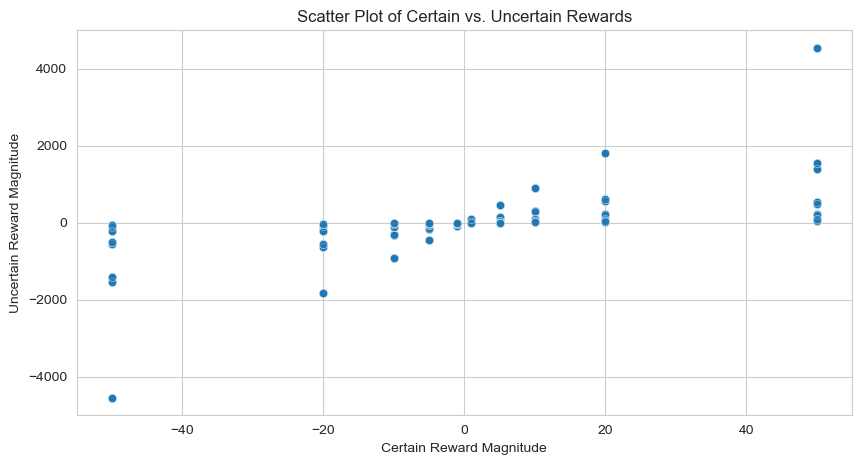

In [27]:
# Scatter Plot: Certain vs. Uncertain Reward Magnitudes
plt.figure(figsize=(10, 5))
sns.scatterplot(x=full_data_train_df['certOutcome'], y=full_data_train_df['uncOutcome'], alpha=0.5)
plt.xlabel('Certain Reward Magnitude')
plt.ylabel('Uncertain Reward Magnitude')
plt.title('Scatter Plot of Certain vs. Uncertain Rewards')
plt.show()

- The spread of the points suggests a range of risk-taking behaviors among participants.
- A clear clustering pattern may indicate that participants were exposed to a few fixed experimental conditions.

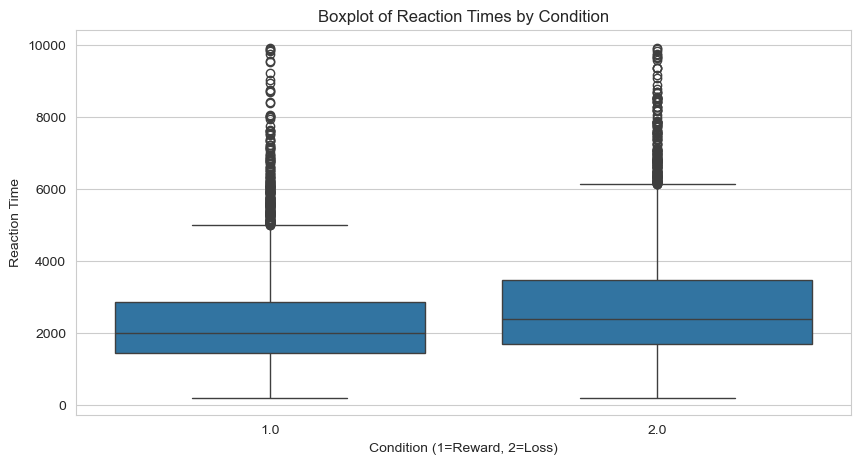

In [28]:
# Boxplot of Reaction Times by Condition
plt.figure(figsize=(10, 5))
sns.boxplot(x=full_data_train_df['condition (1=reward,2=loss)'], y=full_data_train_df['RT'])
plt.xlabel('Condition (1=Reward, 2=Loss)')
plt.ylabel('Reaction Time')
plt.title('Boxplot of Reaction Times by Condition')
plt.show()

- This visualization compares RT distributions for reward-based vs. loss-based decision-making conditions.
- If the median RTs are higher for one condition, it suggests that participants took more time to deliberate.
- The presence of outliers in either condition may indicate difficult trials where participants took longer to decide.
- If reward discounting has a higher median RT, it might indicate more careful deliberation in reward-seeking behavior
- If loss discounting has a higher median RT, it suggests that participants hesitate more when making loss-related decisions.

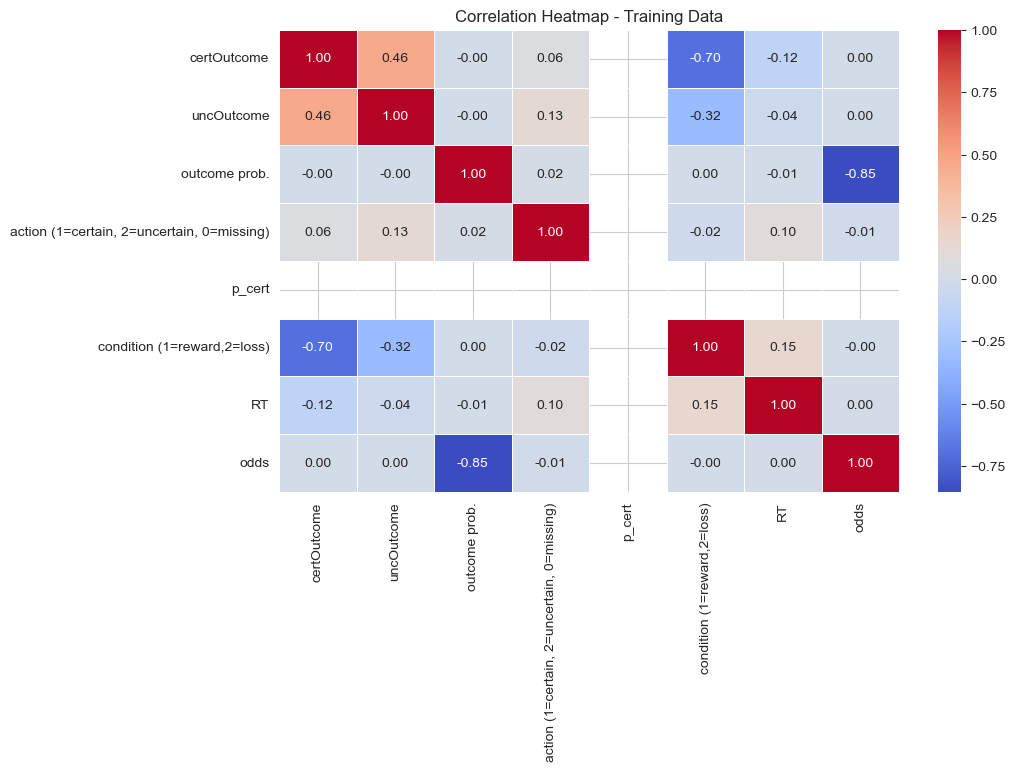

In [29]:
# Correlation Heatmap for Training Data
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap - Training Data')
plt.show()

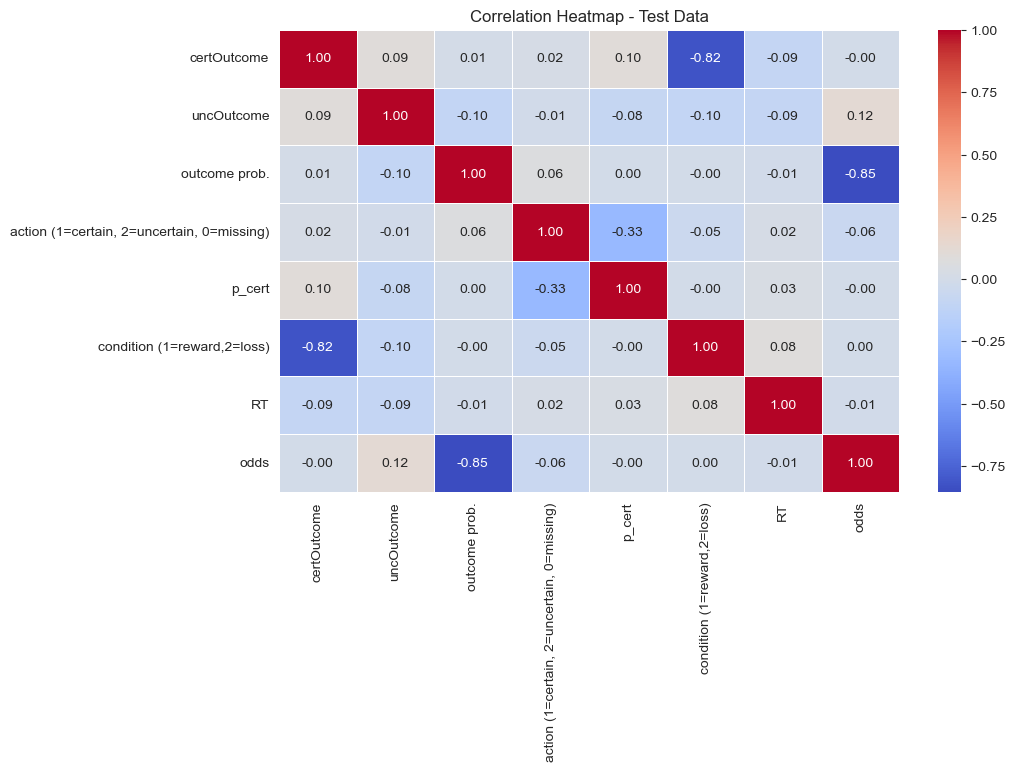

In [30]:
# Correlation Heatmap for Test Data
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_test_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap - Test Data')
plt.show()

In [31]:
# Define Bernoulli Choice Model
def fit_bernoulli_choice_model(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

# Prepare data for choice modeling
X_train = numeric_train_df[["certOutcome", "uncOutcome", "outcome prob.", "odds"]]
y_train = numeric_train_df["action (1=certain, 2=uncertain, 0=missing)"].replace(2, 1) 
X_test = numeric_test_df[["certOutcome", "uncOutcome", "outcome prob.", "odds"]]
y_test = numeric_test_df["action (1=certain, 2=uncertain, 0=missing)"].replace(2, 1)

# Fit Bernoulli choice model
bernoulli_model = fit_bernoulli_choice_model(X_train, y_train)

# Validate the Bernoulli model
accuracy = bernoulli_model.score(X_test, y_test)
print(f"Bernoulli Model Accuracy on Validation Data: {accuracy}")

Bernoulli Model Accuracy on Validation Data: 0.9818367346938776


C:\Users\Keerthan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Keerthan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


In [33]:
# Define Reaction Time Models
def shifted_lognormal_mle(params, rt):
    tau, mu, sigma = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.lognorm.pdf(rt_shifted, s=sigma, scale=np.exp(mu)) + 1e-10))

def inverse_gaussian_mle(params, rt):
    mu, lambda_ = params
    return -np.sum(np.log(stats.invgauss.pdf(rt, mu, scale=lambda_) + 1e-10))

def shifted_weibull_mle(params, rt):
    k, lambda_, tau = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.weibull_min.pdf(rt_shifted, k, scale=lambda_) + 1e-10))

# Fit Models on Training Data
rt_train = numeric_train_df["RT"].dropna()
rt_test = numeric_test_df["RT"].dropna()

# Optuna Optimization
models = ["Shifted Log-Normal", "Inverse Gaussian", "Shifted Weibull"]
best_params = {}

def optimize_model(trial, model_name):
    if model_name == "Shifted Log-Normal":
        return shifted_lognormal_mle([trial.suggest_float("tau", 0.01, 1.0),
                                       trial.suggest_float("mu", np.log(np.mean(rt_train)) - 1, np.log(np.mean(rt_train)) + 1),
                                       trial.suggest_float("sigma", 0.1, 2.0)], rt_train)
    elif model_name == "Inverse Gaussian":
        return inverse_gaussian_mle([trial.suggest_float("mu", np.mean(rt_train) / 2, np.mean(rt_train) * 2),
                                     trial.suggest_float("lambda_", 0.1, 10.0)], rt_train)
    elif model_name == "Shifted Weibull":
        return shifted_weibull_mle([trial.suggest_float("k", 0.1, 5.0), trial.suggest_float("lambda_", 100, 1000), trial.suggest_float("tau", 0.01, 1.0)], rt_train)

for model in models:
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optimize_model(trial, model), n_trials=50)
    best_params[model] = study.best_params

# Compute model comparison metrics
model_comparison = {}
for model, params in best_params.items():
    log_likelihood = -optimize_model(optuna.trial.FixedTrial(params), model)
    k = len(params)
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(len(rt_train)) - 2 * log_likelihood
    model_comparison[model] = {"Log-Likelihood": log_likelihood, "AIC": aic, "BIC": bic}

# Convert to DataFrame
model_comparison_df = pd.DataFrame.from_dict(model_comparison, orient='index')
print("Final Model Comparison Table:")
print(model_comparison_df)


[I 2025-02-28 13:47:34,446] A new study created in memory with name: no-name-ad08df27-b2f5-4a74-8ce0-07c100d2eb93
[I 2025-02-28 13:47:34,456] Trial 0 finished with value: 88302.46233333468 and parameters: {'tau': 0.18281425309386043, 'mu': 7.871615158487054, 'sigma': 1.4581576781521073}. Best is trial 0 with value: 88302.46233333468.
[I 2025-02-28 13:47:34,467] Trial 1 finished with value: 86181.591513531 and parameters: {'tau': 0.4454228214103645, 'mu': 7.62416800561146, 'sigma': 1.114601233112038}. Best is trial 1 with value: 86181.591513531.
[I 2025-02-28 13:47:34,479] Trial 2 finished with value: 85312.33369175212 and parameters: {'tau': 0.9878899195639314, 'mu': 8.032017958824174, 'sigma': 0.6203841875684366}. Best is trial 2 with value: 85312.33369175212.
[I 2025-02-28 13:47:34,490] Trial 3 finished with value: 88351.93189391901 and parameters: {'tau': 0.37812792828348146, 'mu': 8.314585953145874, 'sigma': 1.2601951751382423}. Best is trial 2 with value: 85312.33369175212.
[I 202

Final Model Comparison Table:
                    Log-Likelihood            AIC            BIC
Shifted Log-Normal   -83634.595592  167275.191184  167296.745944
Inverse Gaussian    -109873.558165  219751.116331  219765.486171
Shifted Weibull      -91251.256325  182508.512650  182530.067410


[I 2025-02-28 13:48:24,242] A new study created in memory with name: no-name-5a9fcd02-462e-4b77-9d3d-c8cb3ffa9f43
[I 2025-02-28 13:48:24,249] Trial 0 finished with value: 85550.29094267773 and parameters: {'tau': 0.1377455028623266, 'mu': 8.065825367527214, 'sigma': 0.6375537903832958}. Best is trial 0 with value: 85550.29094267773.
[I 2025-02-28 13:48:24,262] Trial 1 finished with value: 88726.50891013276 and parameters: {'tau': 0.9812150222403595, 'mu': 7.382831681002073, 'sigma': 1.5229567255270897}. Best is trial 0 with value: 85550.29094267773.
[I 2025-02-28 13:48:24,274] Trial 2 finished with value: 91409.56381532406 and parameters: {'tau': 0.3008123205976759, 'mu': 8.618086656156962, 'sigma': 1.8221478732944472}. Best is trial 0 with value: 85550.29094267773.
[I 2025-02-28 13:48:24,283] Trial 3 finished with value: 97961.43412725386 and parameters: {'tau': 0.5677858925201051, 'mu': 8.5147073143515, 'sigma': 0.4994460035854714}. Best is trial 0 with value: 85550.29094267773.
[I 2

Final Model Comparison Table:
                    Log-Likelihood            AIC            BIC
Shifted Log-Normal   -83642.535826  167291.071652  167312.626412
Weibull              -91108.834124  182221.668247  182236.038087
Shifted Weibull      -91285.224905  182576.449809  182598.004569


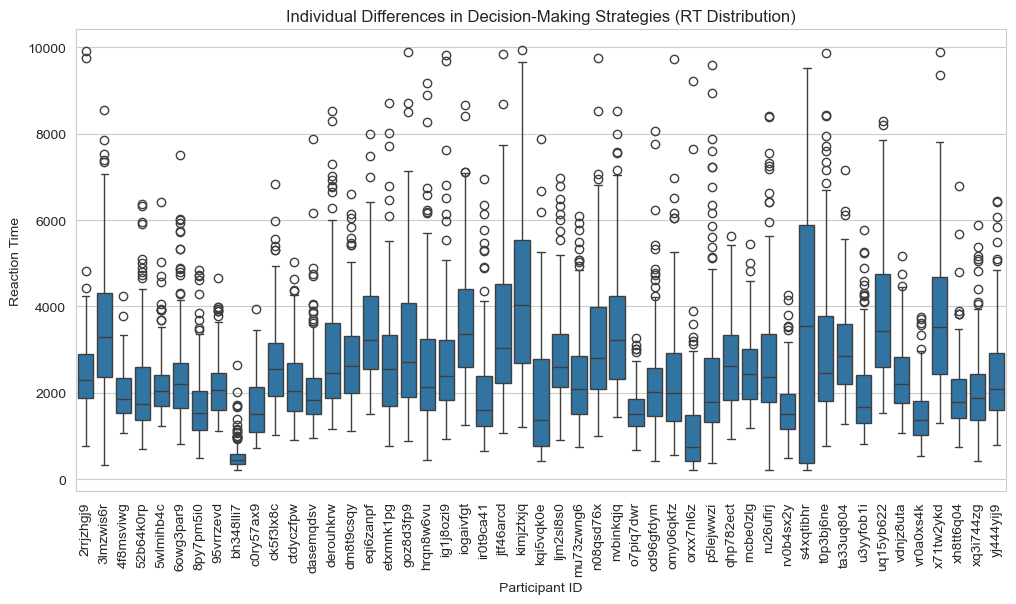

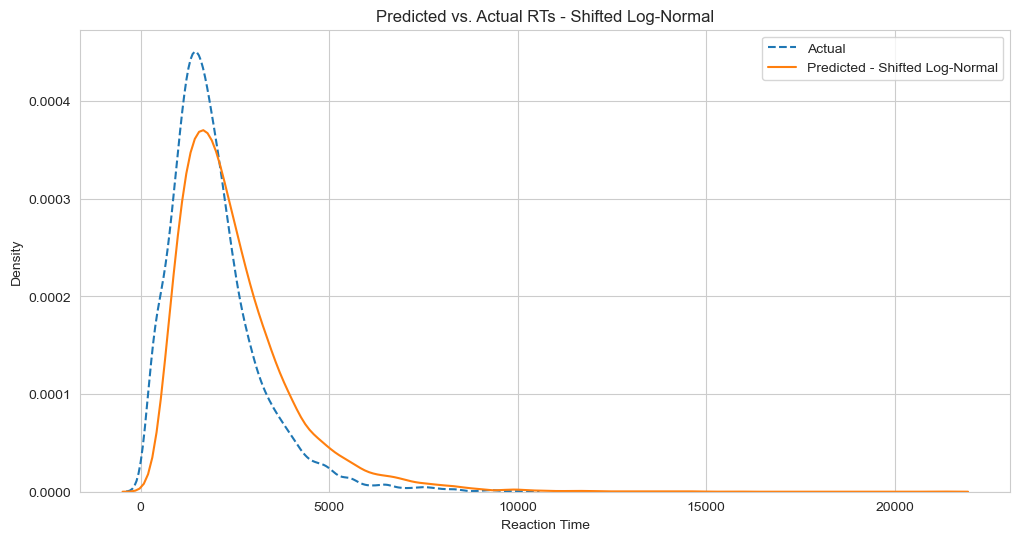

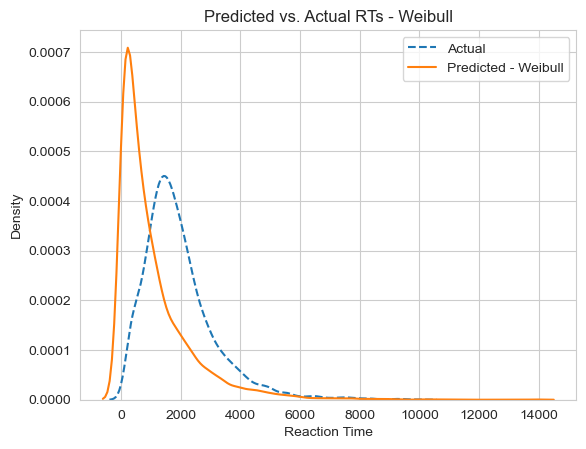

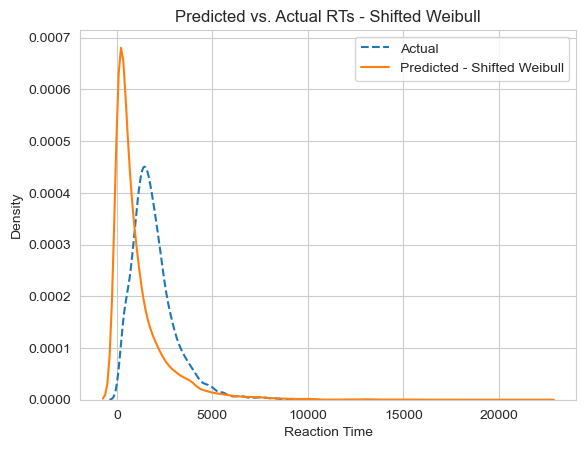

In [34]:
# Define Reaction Time Models
def shifted_lognormal_mle(params, rt):
    tau, mu, sigma = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.lognorm.pdf(rt_shifted, s=sigma, scale=np.exp(mu)) + 1e-10))

def weibull_mle(params, rt):
    k, lambda_ = params
    return -np.sum(np.log(stats.weibull_min.pdf(rt, k, scale=lambda_) + 1e-10))

def shifted_weibull_mle(params, rt):
    k, lambda_, tau = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.weibull_min.pdf(rt_shifted, k, scale=lambda_) + 1e-10))

# Fit Models on Training Data
rt_train = numeric_train_df["RT"].dropna()
rt_test = numeric_test_df["RT"].dropna()

# Optuna Optimization
models = ["Shifted Log-Normal", "Weibull", "Shifted Weibull"]
best_params = {}

def optimize_model(trial, model_name):
    if model_name == "Shifted Log-Normal":
        return shifted_lognormal_mle([trial.suggest_float("tau", 0.01, 1.0),
                                       trial.suggest_float("mu", np.log(np.mean(rt_train)) - 1, np.log(np.mean(rt_train)) + 1),
                                       trial.suggest_float("sigma", 0.1, 2.0)], rt_train)
    elif model_name == "Weibull":
        return weibull_mle([trial.suggest_float("k", 0.1, 5.0), trial.suggest_float("lambda_", 100, 1000)], rt_train)
    elif model_name == "Shifted Weibull":
        return shifted_weibull_mle([trial.suggest_float("k", 0.1, 5.0), trial.suggest_float("lambda_", 100, 1000), trial.suggest_float("tau", 0.01, 1.0)], rt_train)

for model in models:
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optimize_model(trial, model), n_trials=50)
    best_params[model] = study.best_params

# Compute model comparison metrics
model_comparison = {}
predicted_rts = {}

for model, params in best_params.items():
    log_likelihood = -optimize_model(optuna.trial.FixedTrial(params), model)
    k = len(params)
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(len(rt_train)) - 2 * log_likelihood
    model_comparison[model] = {"Log-Likelihood": log_likelihood, "AIC": aic, "BIC": bic}
    
    if model == "Shifted Log-Normal":
        predicted_rts[model] = stats.lognorm.rvs(s=params["sigma"], scale=np.exp(params["mu"]), size=len(rt_test)) + params["tau"]
    elif model == "Weibull":
        predicted_rts[model] = stats.weibull_min.rvs(c=params["k"], scale=params["lambda_"], size=len(rt_test))
    elif model == "Shifted Weibull":
        predicted_rts[model] = stats.weibull_min.rvs(c=params["k"], scale=params["lambda_"], size=len(rt_test)) + params["tau"]

# Convert to DataFrame
model_comparison_df = pd.DataFrame.from_dict(model_comparison, orient='index')
print("Final Model Comparison Table:")
print(model_comparison_df)

# Analyze Individual Differences in Decision-Making Strategies
plt.figure(figsize=(12, 6))
sns.boxplot(x=full_data_train_df["participant_id"], y=full_data_train_df["RT"])
plt.xticks(rotation=90)
plt.xlabel("Participant ID")
plt.ylabel("Reaction Time")
plt.title("Individual Differences in Decision-Making Strategies (RT Distribution)")
plt.show()

# Plot predicted vs. actual RTs
plt.figure(figsize=(12, 6))
for model, preds in predicted_rts.items():
    sns.kdeplot(rt_test, label="Actual", linestyle="--")
    sns.kdeplot(preds, label=f"Predicted - {model}")
    plt.title(f"Predicted vs. Actual RTs - {model}")
    plt.xlabel("Reaction Time")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
